## Distance Fluctuations

In [1]:
from make_model import loadModes, modeCalc

In [2]:
pdb = '2e0z'
n_modes = 300
evals, evecs, kirch = loadModes(pdb, n_modes)

../results/models/2e0zanmmodes.npz
Loading anm Modes
Slicing Modes up to 300
(126000, 300)


In [3]:
from make_model import distanceFlucts

In [4]:
n_calc = 3*int(kirch.shape[0]/(180))
kirchD = kirch.copy()
kirchD[:n_calc,:n_calc] = 1

C:\Users\colin\miniconda3\envs\odep\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


300
Direct Calculation Method
0.39409307542761546
0.0
Plotting Fluctuation Histogram


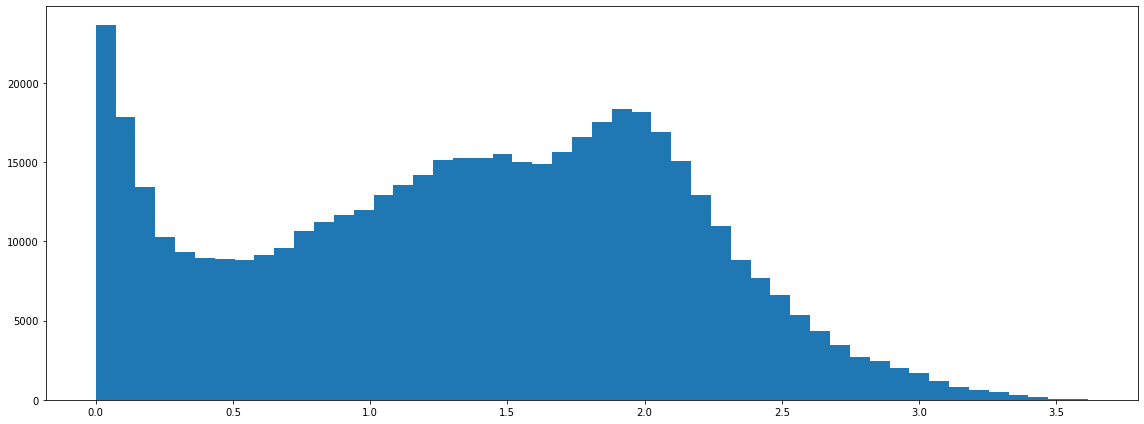

In [5]:
distFlucts = distanceFlucts(evals, evecs[:n_calc,:], kirchD[:n_calc,:n_calc], n_modes)

In [6]:
import numpy as np
dat = np.load('../results/subdivisions/' + pdb + '_sqFlucts.npz')
k = dat['k']
gamma = (8 *np.pi**2)/k
print(gamma)

62.4527893944065


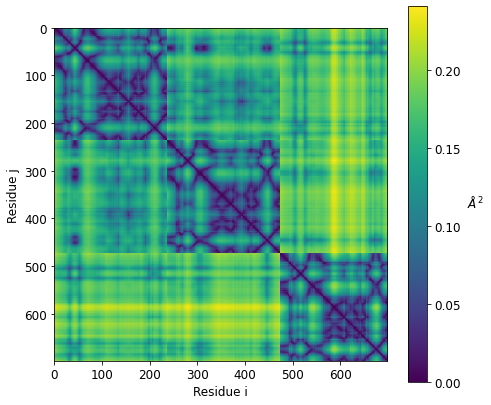

In [12]:
import matplotlib
font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 12}
matplotlib.rc('font', **font)

plotMatD = np.sqrt(distFlucts[:n_calc, :n_calc].todense()/gamma)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,6))
mat = ax.imshow(plotMatD, interpolation='none')
ax.set_xlabel('Residue i')
ax.set_ylabel('Residue j')
cb = plt.colorbar(mat)
cb.ax.get_yaxis().labelpad = 15
cb.set_label(r'$Å^2$', rotation=0)
fig.tight_layout()
plt.savefig('../results/subdivisions/' + pdb + 'dflucts.svg')
plt.show()

300
Direct Calculation Method
0.0
0.0
Plotting Fluctuation Histogram


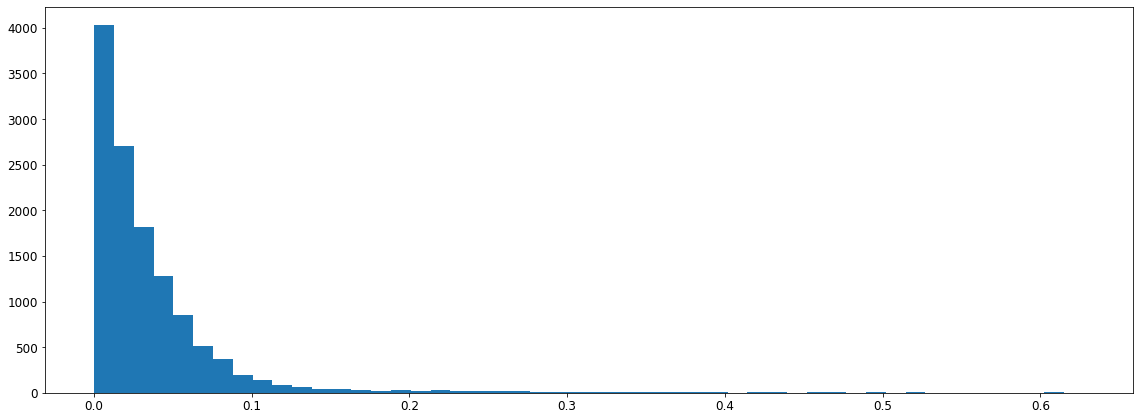

In [31]:
from make_model import fluctToSims
from scipy import sparse
distFlucts = distanceFlucts(evals, evecs[:n_calc,:], kirch[:n_calc,:n_calc], n_modes)
sims = fluctToSims(distFlucts, pdb)

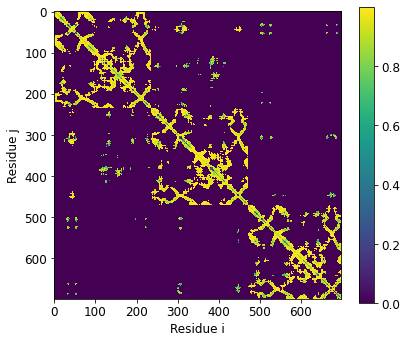

In [33]:
import matplotlib
font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 12}
matplotlib.rc('font', **font)

plotMat = np.sqrt(sims.todense()[:int(n_calc), :int(n_calc)])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,5))
mat = ax.imshow(plotMat, interpolation='none')
ax.set_xlabel('Residue i')
ax.set_ylabel('Residue j')
cb = plt.colorbar(mat)
cb.ax.get_yaxis().labelpad = 15
#cb.set_label(r'$Å^2$', rotation=0)
fig.tight_layout()
plt.savefig('../results/subdivisions/' + pdb + 'sims.svg')
plt.show()

## Compressibility

In [140]:
%load_ext autoreload
%autoreload 2
import numpy as np
from make_model import getPDB, getPDBx, buildModel, modeCalc
pdb = '3tim'
pdbx = False
if pdbx:
    capsid, calphas, coords, bfactors, title = getPDBx(pdb)
else:
    capsid, calphas, title, header = getPDB(pdb)
    coords = calphas.getCoords()
    bfactors = calphas.getBetas()

m = np.sum(capsid.getMasses())/coords.shape[0]
print(m)
hess, kirch = buildModel(pdb, calphas, coords, bfactors, cutoff=10)
evals, evecs = modeCalc(pdb, hess, kirch, 300, 'lobcuda', 'anm')

@> 3808 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Secondary structures were assigned to 275 residues.
@> Biomolecular transformations were applied to the coordinate data.
@> WARNING hybrid36 format is being used


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
AtomGroup 3tim_full biomolecule 1
Number Of Residues:  498
99.80398714859436
# Atoms  498
d2 mode
nonzero values:  9382
kirch:  [0.11011625 0.29106134 0.37048887 0.35588827 0.53424347 0.5489779
 0.60154956 0.6451822  0.59182677 0.60642503 0.55933991 0.58995547
 0.5891717  0.50786672 0.45709547 0.39966282 0.35730374 0.29896051
 0.35716258 0.47459537 0.44656261 0.38292193 0.46402601 0.49188535
 0.41627603 0.41789093 0.4960993  0.47044413 0.32739568 0.36041788
 0.27152489 0.34676212 0.24364168 0.30986091 0.30875747 0.46203931
 0.43476751 0.52988394 0.52852824 0.58017407 0.64339433 0.58509824
 0.57974944 0.54060591 0.50853667 0.52998587 0.55419931 0.43941762
 0.40654789 0.49473747 0.44360175 0.28451937 0.35852582 0.46214563
 0.34775866 0.40718703 0.27399965 0.40824832 0.4658684  0.43607631
 0.49256207 0.65396056 0.61118187 0.59619823 0.53968176 0.50911947
 0.47665404 0.43711371 0.3801097  0.43823062 0.3

In [141]:
from make_model import loadModes, modeCalc
n_modes = 300
evals, evecs, kirch = loadModes(pdb, n_modes)
if coords.shape[0] == evecs.shape[0]:
    model = 'gnm'
else:
     model='anm'
print(evecs.shape)

../results/models/3timanmmodes.npz
Loading anm Modes
Slicing Modes up to 300
(1494, 300)
(1494, 300)


In [142]:
from score import volFlucts
from bfactorFit import fluctFit
import numpy as np
nModes, coeff, k, sqFlucts, stderr, r2 = fluctFit(evals, evecs, bfactors)

boltz = 1.38e-23
dalt = 6.022*10**26
bz = boltz*10**20*dalt
T_scale = 270
T_sim = 270

gamma = T_scale*bz*(8 * np.pi ** 2) / k

stderr =  stderr/k

if model == 'anm':
    gamma = gamma / 3

print(k, gamma)

gamma = gamma*m # average mass in daltons per residue

scale = T_sim*bz

compressibility, vrms, vplot, vmodes = volFlucts(coords, evals, evecs, gamma=gamma)
print(np.sqrt(scale*vrms), compressibility)

0.4195527627022251 1.4075553900230683e+28
(498, 3)
(1494, 300)
vol 76021.14868414983
3.907733737171013e-23
7
371.0680535592576 8.072147760119471e-27


In [136]:
scgs = 1e-8*6.022e23
print(scgs*compressibility)
spa = 1e-10*6.022e26
print(spa*compressibility*10e9)

4.861047381143945e-11
4.861047381143946


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


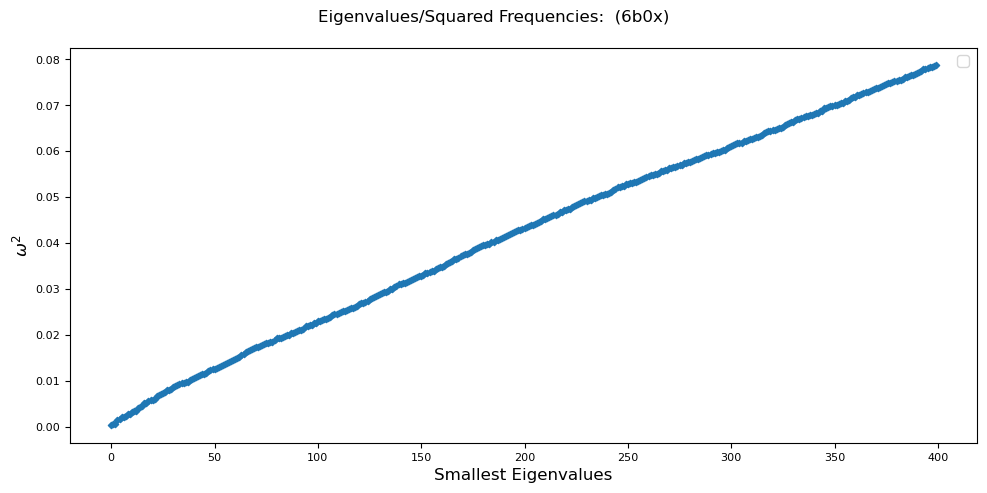

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting compressibility by modes


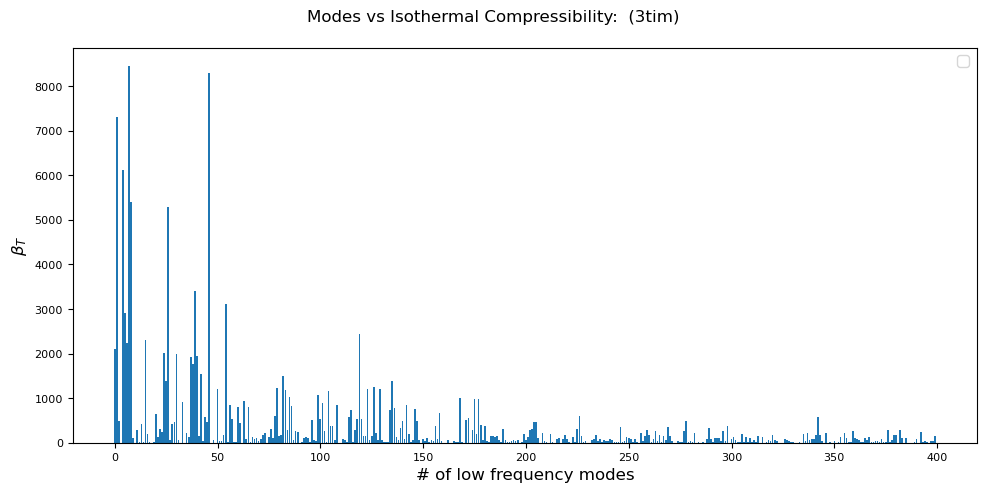

In [109]:
import matplotlib.pyplot as plt
import matplotlib
from make_model import evPlot
evPlot(evals, evecs, title)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 11}
matplotlib.rc('font', **font)
print('Plotting compressibility by modes')
ax.set_ylabel(r'$\beta_{T}$', fontsize=12)
ax.set_xlabel('# of low frequency modes', fontsize=12)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.legend()
fig.suptitle(
    'Modes vs Isothermal Compressibility: ' + ' (' + pdb + ')', fontsize=12)

#ax.scatter(np.arange(vplot.shape[0]), scale*vplot, marker='D', s=10, label='eigs')
ax.bar(np.arange(vplot.shape[0]), scale*vplot)
fig.tight_layout()
plt.savefig('../results/subdivisions/' + pdb + '_evals.png')
plt.show()

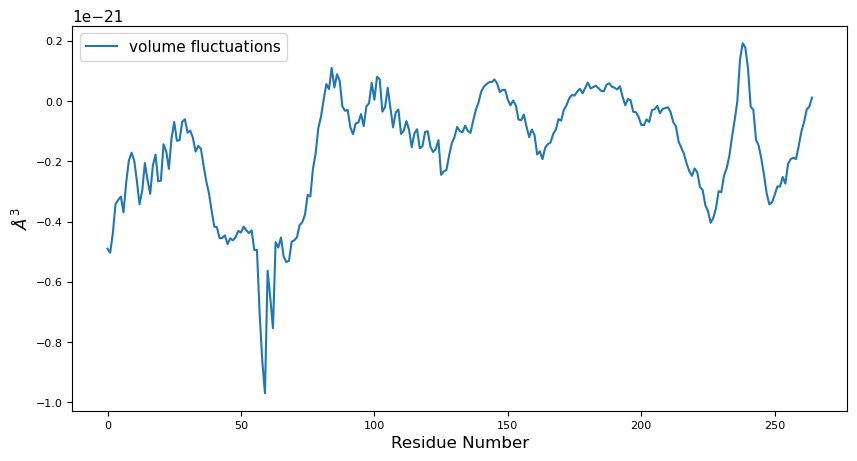

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 11}
matplotlib.rc('font', **font)


n_asym = int(bfactors.shape[0]/60)
#np.savez('../results/subdivisions/' + pdb + '_sqFlucts.npz', sqFlucts=sqFlucts, bf=bfactors, k=k, cc=coeff, nModes=nModes)
ax.plot(np.arange(bfactors.shape[0])[:int(n_asym)], vmodes[:int(n_asym)], label='volume fluctuations')

ax.set_ylabel(r'$Å^{3}$', fontsize=12)
ax.set_xlabel('Residue Number', fontsize=12)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=8)

ax.legend()
# fig.suptitle(
#     'Squared Fluctuations vs B-factors: '  + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(
#         gamma) +  r'$\pm$' + "{:.5f}".format(ci) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff)  + '  r2 = ' + "{:.5f}".format(r2), fontsize=12)
# fig.suptitle('# Modes: ' + str(nModes) + ' Corr. Coeff: ' + str(coeff) + ' Spring Constant: ' + str(gamma), fontsize=16)
# fig.tight_layout()
# plt.savefig('../results/subdivisions/' + pdb + '_sqFlucts.svg')
# plt.savefig('../results/subdivisions/' + pdb + '_sqFlucts.png')
plt.show()

## Score Plot

Plotting
[  0.  50. 100. 150. 200. 250.]
[  0.  50. 100. 150. 200. 250. 238.]
6nj8_238_domains.png


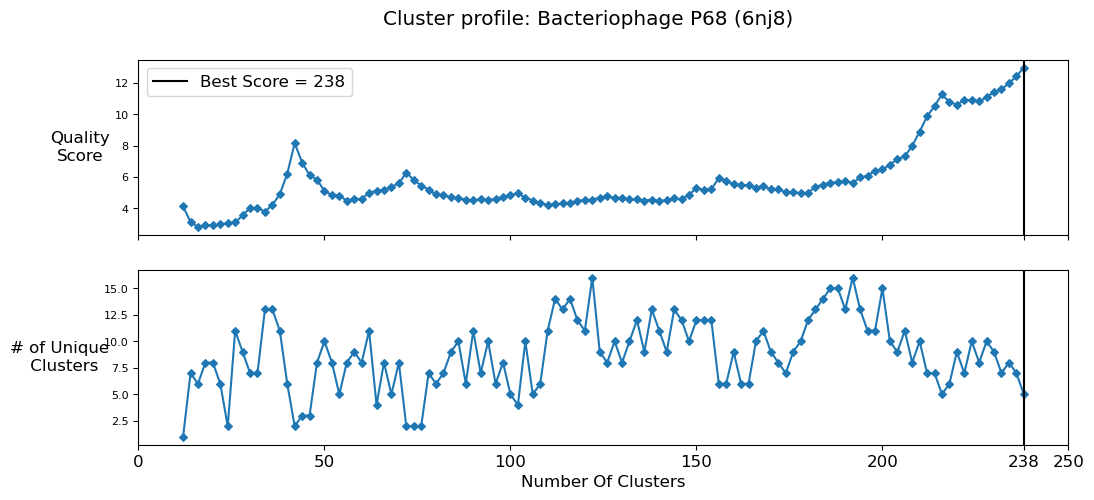

In [1]:
from score import plotScores
import numpy as np

pdb = '6nj8'
nstart = 12
nstop = 240
nstep = 2

n_range = np.arange(nstart,nstop,nstep)

import matplotlib
import matplotlib.pyplot as plt
from make_model import getPDB

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}

#_, _, title = getPDB(pdb)

title = 'Bacteriophage P68'

matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')


scores = []
vars = []
ntypes = []
inerts = []
for i in range(len(n_range)):
    nc = n_range[i]
    results = np.load('../results/subdivisions/' + pdb + '/' + pdb + '_' + str(nc) + '_results.npz')
    score = results['score']
    ntype = results['ntypes']
    var = results['var']
    #inert = results['inertia']
    scores.append(score)
    vars.append(var)
    ntypes.append(ntype)
    #inerts.append(inert)
scores = np.array(scores)
vars = np.array(vars)
ntypes = np.array(ntypes)


print('Plotting')
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
fig.suptitle('Cluster profile: ' + title.title() + ' (' + pdb + ')')

ax[0].scatter(n_range, scores, marker='D', s=15)
ax[0].plot(n_range, scores)
ax[1].plot(n_range, ntypes)
ax[1].scatter(n_range, ntypes, marker='D', s=15)
#ax[2].scatter(n_range, inerts, marker='D', s=15)
#ax[2].plot(n_range, inerts)
ax[0].axvline(x=n_range[np.argmax(scores)], label='Best Score = ' + str(n_range[np.argmax(scores)]) , color='black')
ax[1].axvline(x=n_range[np.argmax(scores)], label='Best Score', color='black')

nc = str(n_range[np.argmax(scores)])
# ax[0].set_xticks(n_range)
ax[1].set_xlim([0, n_range[-1]])
ticks = ax[0].get_xticks()
print(ticks)
ticks = np.append(ticks, n_range[np.argmax(scores)])

ax[1].set_xlabel('Number Of Clusters')
ax[0].set_ylabel('Quality' + '\n' + 'Score', rotation='horizontal', ha='center', va='center', labelpad=25)
ax[1].set_ylabel('# of Unique \n Clusters', rotation='horizontal', ha='center', va='center', labelpad=30)
#ax[2].set_ylabel('Cluster \n Inertia', rotation='horizontal', ha='center', va='center', labelpad=25)

ax[0].tick_params(axis='y', labelsize=8)
ax[1].tick_params(axis='y', labelsize=8)
#ax[2].tick_params(axis='y', labelsize=8)

print(ticks)
ax[0].legend()
#fig.delaxes(ax[2])
ax[1].set_xticks(ticks, fontsize=6)
# fig.tight_layout()
print(pdb + '_' + nc + '_domains.png')
plt.savefig('../results/subdivisions/' + pdb + '_' + nc + '_domains.png')
plt.show()

Best Scores
[252 250 248 246 254 244 256 242 258 240 260 262 264 238 266 298 236 294
 268 270 272 296 274 234 288 282 232 286 292 276]
[16 14 18 22 50 26 24 28 64 38]
Plotting


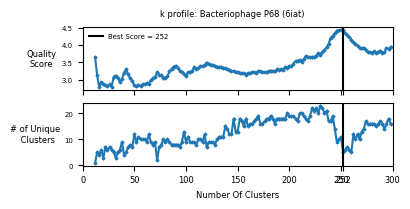

In [15]:
from score import plotScores
pdb = '6iat'
title = 'Bacteriophage P68'
nstart = 12
nstop = 300
nstep = 2

n_range = np.arange(nstart,nstop,nstep)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from make_model import getPDB

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 6}

#_, _, title = getPDB(pdb)

matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')


scores = []
vars = []
ntypes = []
inerts = []
for i in range(len(n_range)):
    nc = n_range[i]
    results = np.load('../results/subdivisions/' + pdb + '/' + pdb + '_' + str(nc) + '_results.npz')
    score = results['score']
    ntype = results['ntypes']
    var = results['var']
    #inert = results['inertia']
    scores.append(score)
    vars.append(var)
    ntypes.append(ntype)
    #inerts.append(inert)
scores = np.array(scores)
vars = np.array(vars)
ntypes = np.array(ntypes)

print('Best Scores')
#ind = np.argpartition(scores,-50)[-50:]
ind = np.argsort(scores)[-30:]
print(n_range[ind][::-1])

ind = np.argsort(vars)[-10:]
print(n_range[ind][::-1])

print('Plotting')
fig, ax = plt.subplots(2, 1, figsize=(4, 1.8), sharex=True)
fig.suptitle('k profile: ' + title.title() + ' (' + pdb + ')', fontsize=6)
ax[0].scatter(n_range, scores, marker='D', s=2)
ax[0].plot(n_range, scores)
ax[1].plot(n_range, ntypes)
ax[1].scatter(n_range, ntypes, marker='D', s=2)
ax[0].axvline(x=n_range[np.argmax(scores)], label='Best Score = ' + str(n_range[np.argmax(scores)]) , color='black')
ax[1].axvline(x=n_range[np.argmax(scores)], label='Best Score', color='black')
ax[1].set_xlim([0, nstop])
ax[0].set_xlim([0, nstop])
ticks = ax[0].get_xticks()
ticks = np.append(ticks, n_range[np.argmax(scores)])
ax[1].set_xlabel('Number Of Clusters')
ax[0].set_ylabel('Quality' + '\n' + 'Score', rotation='horizontal', ha='center', va='center', labelpad=15)
ax[1].set_ylabel('# of Unique \n Clusters', rotation='horizontal', ha='center', va='center', labelpad=20)

ax[0].tick_params(axis='y', labelsize=5)
ax[1].tick_params(axis='y', labelsize=5)

ax[0].legend(fontsize=5, frameon=False)
ax[1].set_xticks(ticks, fontsize=5, prop={'size': 4})
#fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/' + pdb + '_score_final.svg')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/' + pdb + '_score_final.png', dpi=300)
plt.show()

## Squared Fluctuations Figure

In [1]:
pdb = '6b23'
n_modes = 500
from settings import model
from make_model import getPDB, loadModes
evals, evecs, kirch = loadModes(pdb, n_modes)
capsid, calphas, title = getPDB(pdb)
bfactors = calphas.getBetas()
n_asym = 3*int(kirch.shape[0]/(180))

../results/models/6b23anmmodes.npz
Loading anm Modes
Slicing Modes up to 500
(221760, 460)


FileNotFoundError: [Errno 2] No such file or directory: '../results/models/6b23kirch.npz'

In [5]:
from bfactorFit import fluctFit
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from score import collectivity, meanCollect, effectiveSpringConstant, overlapStiffness, globalPressure
_, _, title = getPDB(pdb)
print('Plotting')
nModes, coeff, k, sqFlucts, stderr = fluctFit(evals, evecs, bfactors)

@> 43481 atoms and 1 coordinate set(s) were parsed in 0.36s.
@> Secondary structures were assigned to 2059 residues.
@> Biomolecular transformations were applied to the coordinate data.


AtomGroup 6j3q_full biomolecule 1
Number Of Residues:  344880


@> WARNING Indices are exceeding 99999 and hybrid36 format is being used


Plotting


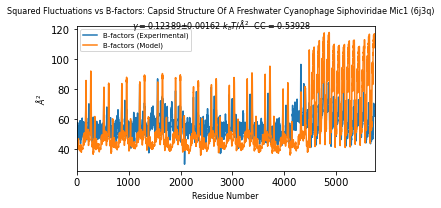

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8/1.5, 4/1.5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

gamma = (8 * np.pi ** 2) / k
stderr =  stderr/k


if model == 'anm':
    gamma = gamma / 3

stderr = gamma * stderr

ax.plot(np.arange(bfactors.shape[0])[:int(n_asym)], bfactors[:int(n_asym)], label='B-factors (Experimental)')
ax.plot(np.arange(sqFlucts.shape[0])[:int(n_asym)], sqFlucts[:int(n_asym)], label='B-factors (Model)')
ax.set_ylabel(r'$Å^{2}$', fontsize=8)
ax.set_xlabel('Residue Number', fontsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlim([-1,n_asym])
ax.legend()
fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) +  r'$\pm$' + "{:.5f}".format(stderr) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff), fontsize=8)
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + pdb + '_sqFlucts_final.svg')
plt.show()

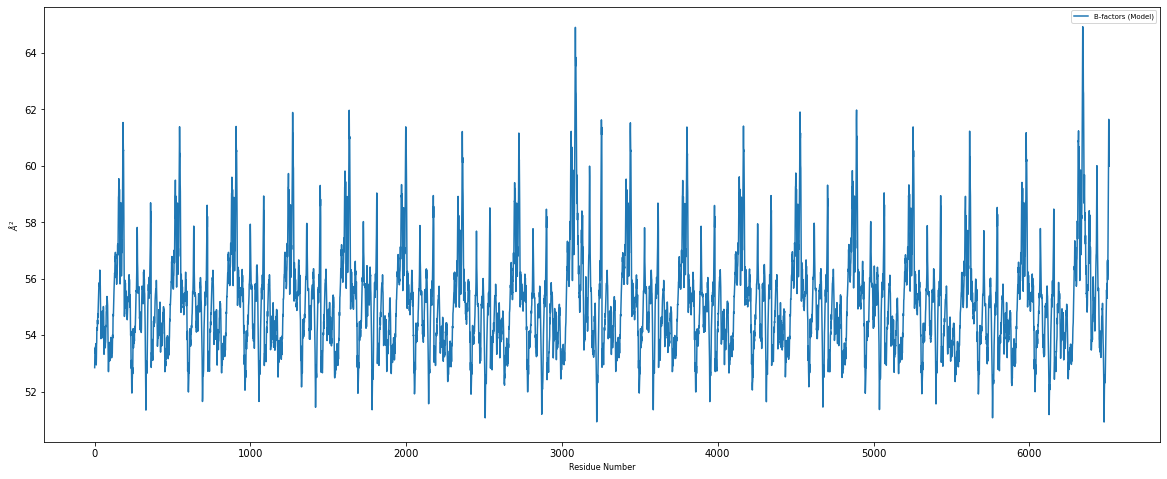

In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
pdb = '7f38'

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

data = np.load('../results/subdivisions/' + pdb + '_sqFlucts.npz')
sqFlucts = data['sqFlucts']
n = sqFlucts.shape[0]
nplot = int(n/30)

ax.plot(np.arange(nplot), sqFlucts[:nplot], label='B-factors (Model)')
ax.set_ylabel(r'$Å^{2}$', fontsize=8)
ax.set_xlabel('Residue Number', fontsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
#ax.set_xlim([-1,n_asym])
ax.legend()
#fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) +  r'$\pm$' + "{:.5f}".format(stderr) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff), fontsize=8)
#plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + pdb + '_sqFlucts_final.svg')
plt.show()

In [1]:
from optcutoff import fluctFit
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from score import collectivity, meanCollect, effectiveSpringConstant, overlapStiffness, globalPressure
_, _, title = getPDB(pdb)
print('Plotting')
nModes, coeff, k, sqFlucts = fluctFit(evals, evecs, bfactors)

ModuleNotFoundError: No module named 'optcutoff'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


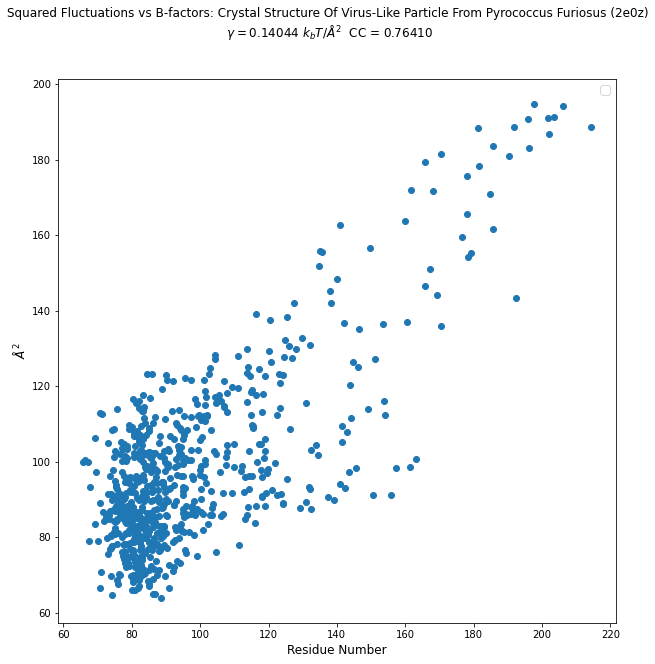

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

gamma = (8 *np.pi**2)/k

bf = bfactors[:int(n_asym)]
sf = sqFlucts[:int(n_asym)]
ind = np.argsort(bf)
bf = bf[ind]
sf = sf[ind]
rg = np.arange(bf.shape[0])

ax.scatter(sf,bf)
#ax.scatter(rg,sf, label='sf')
#ax.scatter(rg,bf)
ax.set_ylabel(r'$Å^{2}$', fontsize=12)
ax.set_xlabel('Residue Number', fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

ax.legend()
fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) + r' $k_{b}T/Å^{2}$' + '  CC = ' +"{:.5f}".format(coeff) ,fontsize=12)
plt.savefig('../results/subdivisions/' + pdb + '_sqFlucts.svg')
plt.show()

## Memory Plot

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

In [2]:
mib = [1245.8, 1977.5, 3553.9, 4317.5, 6038.1, 11000, 18377.8,19626, 7718,14671, 18768,  7700, 12087, 24330, 37603, 44781.7, 45355.71, 15472, 16778]
res = np.array([16320,42000,49860,67740,125820, 136440,180600,177240,126720,199080, 187320, 117600, 174720,344880, 195420, 265200, 266460, 144060, 144060])
Ts = [1,3,3,4,7,7,7,7,7,7,7,7,7,13,13]
mb = 1.0486*np.array(mib)/1000

[1340.50872716]
187.2258411203086
slope:  [0.00011591]
[0.62316585]
stderr:  [0.00011124]


C:\Users\colin\AppData\Local\Temp\ipykernel_16040\3115260296.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params, residuals, _, _ = np.linalg.lstsq(res[:,np.newaxis], mb)


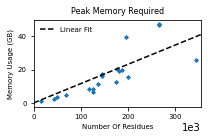

In [3]:
params, residuals, _, _ = np.linalg.lstsq(res[:,np.newaxis], mb)
print(residuals)
r2 = 1 - residuals/(mb.shape[0]*np.var(mb))
stderr = np.sqrt(1/(mb.shape[0]-2) * residuals/(np.var(res)))
print(np.var(mb))
print('slope: ', params)
print(r2)
poly = np.poly1d([params[0],0])
line = np.poly1d([0,32])
intersect = (poly - line).roots
print('stderr: ', stderr)
x = np.linspace(0,np.max(res) + 10000)
fig, ax = plt.subplots(1, 1, figsize = (3,1.6))
ax.set_title('Peak Memory Required', fontsize=8)
ax.plot(x, poly(x), '--', label='Linear Fit', color='black' )

ax.scatter(res, mb, marker='D', s=7)

#ax.plot(x, line(x), label='Maximum Memory', color='black')
#ax.hlines(32,0,2*np.max(res), label='Maximum Memory')
ax.set_ylabel('Memory Usage (GB)', fontsize=7)
ax.set_xlabel('Number Of Residues', fontsize=7)
ax.set_xlim(0,np.max(res) + 10000)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ticklabel_format(axis='x',style='sci', scilimits=(3,3))
ax.legend(frameon=False, fontsize=7)
# fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + 'memPlot.svg')
plt.show()

In [4]:
t = [436, 12000, 16038, 23392, 35541, 52608, 43471, 11884, 114950, 32441, 11983, 53057, 58000, 35747.57, 39339.2, 52528.1, 13302.4, 21428.8, 27734.7, 29117.6]
t = np.array(t)/3600
res = np.array([16320, 42000, 49860, 125820,  180600, 177240, 187320, 117600, 344880, 212100, 67740, 225420, 104760, 195420, 265200, 266460, 126720, 144060, 144060, 114060])

C:\Users\colin\AppData\Local\Temp\ipykernel_16040\3443855181.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params, residuals, _, _ = np.linalg.lstsq(res[:,np.newaxis], t)


[325.49551363]
slope:  [6.26505797e-05]
[0.90849905]
stderr:  [5.41023434e-05]


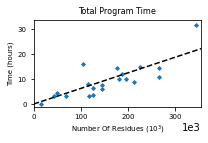

In [5]:
#params = np.polyfit(res,t,1)
params, residuals, _, _ = np.linalg.lstsq(res[:,np.newaxis], t)
print(residuals)
r2 = 1 - residuals/(mb.shape[0]*np.var(mb))
stderr = np.sqrt(1/(mb.shape[0]-2) * residuals/(np.var(res)))
print('slope: ', params)
print(r2)
print('stderr: ', stderr)
poly = np.poly1d([params[0],0])
x = np.linspace(0,np.max(res) + 10000)
fig, ax = plt.subplots(1, 1, figsize = (3,1.6))
ax.set_title('Total Program Time', fontsize=8)
ax.plot(x, poly(x), '--', label='Linear Fit', color='black')
ax.scatter(res, t, marker='D', s=7)
ax.set_ylabel('Time (hours)', fontsize=7)
ax.set_xlabel('Number Of Residues ($10^3$)', fontsize=7)
ax.set_xlim(0,np.max(res) + 10000)
ax.set_ylim(-1, np.max(t)+2)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ticklabel_format(axis='x',style='sci', scilimits=(3,3))
#ax.legend()
# fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + 'timePlot.svg')
plt.show()

## Spring Constants

In [10]:
pdbs = ['3dkt',
'2e0z',
'4pt2',
'6nj8',
'6c21',
'3j4u',
'5uu5',
'5l35',
#'5wk1',
#'7eel',
'3j7v',
'6xgq',
'1ohg',
'3j40',
'6j3q',
#'5vf3'
       ]

In [11]:
import numpy as np
gammas = []
ccs = []
ns = []
errors = []
for cap in pdbs:
    data = np.load('../results/subdivisions/' + cap + '_sqFlucts.npz')
    k = data['k']
    cc = data['cc']
    sq = data['sqFlucts']
    n = sq.shape[0]
    ns.append(n)
    gamma = (8 *np.pi**2)/k
    gammas.append(gamma)
    ccs.append(float(cc))
    err = (1-cc**2)/(np.sqrt(n))
    errors.append(err)

In [13]:
print(pdbs)
print(gammas)
print(ccs)

['3dkt', '2e0z', '4pt2', '6nj8', '6c21', '3j4u', '5uu5', '5l35', '3j7v', '6xgq', '1ohg', '3j40', '6j3q']
[0.03761032545206781, 1.3357397287602666, 0.1455363692191531, 0.11165987085900293, 0.03579359827015194, 0.052103484107891736, 0.013013214164806773, 0.12504152820374326, 0.0514800564560779, 3.3268030986998647, 0.04866184221407472, 2.675491827731548, 0.08553061136707873]
[0.08822232856189909, 0.7004956607260657, 0.20410731814706098, 0.2836912918165937, -0.08591056643074195, 0.431037144997198, 0.49499199624880946, 0.43427968763460173, 0.27573998492483226, 0.24390256913374656, -0.012602904234112894, 0.378468936292586, 0.4086662323587634]


In [14]:
for i in range(len(pdbs)):
    print((pdbs[i],gammas[i], ccs[i]))

('3dkt', 0.03761032545206781, 0.08822232856189909)
('2e0z', 1.3357397287602666, 0.7004956607260657)
('4pt2', 0.1455363692191531, 0.20410731814706098)
('6nj8', 0.11165987085900293, 0.2836912918165937)
('6c21', 0.03579359827015194, -0.08591056643074195)
('3j4u', 0.052103484107891736, 0.431037144997198)
('5uu5', 0.013013214164806773, 0.49499199624880946)
('5l35', 0.12504152820374326, 0.43427968763460173)
('3j7v', 0.0514800564560779, 0.27573998492483226)
('6xgq', 3.3268030986998647, 0.24390256913374656)
('1ohg', 0.04866184221407472, -0.012602904234112894)
('3j40', 2.675491827731548, 0.378468936292586)
('6j3q', 0.08553061136707873, 0.4086662323587634)


## Capsid Correlations

In [4]:
import pandas as pd
import numpy as np
# table = pd.read_csv('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/results_table_correct.csv', sep=',')
table = pd.read_excel('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/results_table_correct.xlsx')

print(table.keys())

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

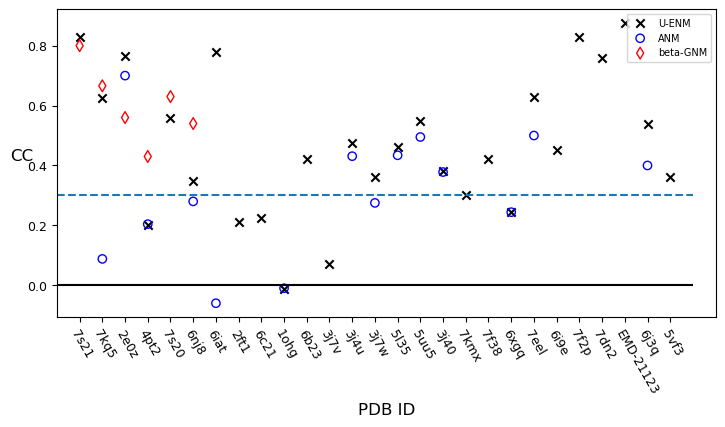

In [87]:
import matplotlib.pyplot as plt
import matplotlib
rs = np.array(table['Residues'])
titles = np.array(table['PDB'])
CCs = np.array(table['CC'])
CCs0 = np.array(table['CCanm'])
CCsb = np.array(table['CCbgnm'])
csort = np.argsort(rs)
CCs = CCs[csort]
CCs0 = CCs0[csort]
CCsb = CCsb[csort]
titles = titles[csort]
ind = np.arange(CCs.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.scatter(ind, CCs, marker = 'x', color='black', label='U-ENM')
ax.scatter(ind, CCs0, marker = 'o', color='blue', facecolors='none', label='ANM')
ax.scatter(ind, CCsb, marker = 'd', color='red', facecolors='none', label='beta-GNM')

ax.hlines(0.3, -1, CCs.shape[0], linestyles='dashed')
ax.hlines(0, -1, CCs.shape[0], color='black')

ax.set_ylabel('CC', fontsize=12, rotation=0)
ax.set_xlabel('PDB ID', fontsize=12)
ax.set_xticks(ind, labels=titles, rotation = -60, ha='left', rotation_mode='anchor')
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
ax.xaxis.set_tick_params(which='minor', pad=5)
#ax.set_ylim([0,1])
ax.set_xlim([-1,CCs.shape[0]+1])
ax.legend()
#fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) +  r'$\pm$' + "{:.5f}".format(stderr) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff), fontsize=8)
#plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + pdb + '_sqFlucts_final.svg')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


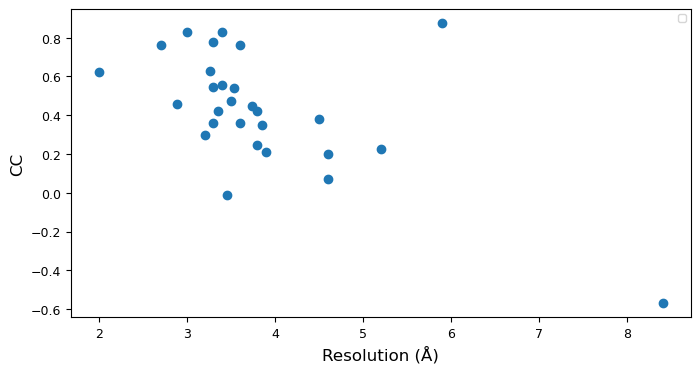

In [65]:
import matplotlib.pyplot as plt
import matplotlib
res = np.array(table['Resolution'])
CCs = np.array(table['CC'])
ind = np.arange(CCs.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.scatter(res, CCs)
ax.set_ylabel('CC', fontsize=12)
ax.set_xlabel('Resolution (Å)', fontsize=12)
#ax.set_xticks(ind, labels=titles, rotation = 70)
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
ax.legend()
#fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) +  r'$\pm$' + "{:.5f}".format(stderr) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff), fontsize=8)
#plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + pdb + '_sqFlucts_final.svg')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


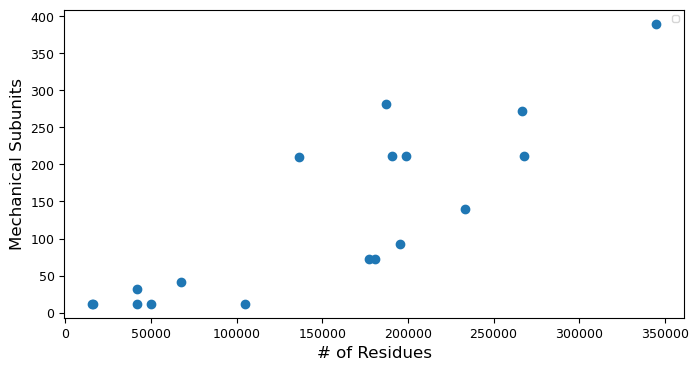

In [4]:
import matplotlib.pyplot as plt
import matplotlib
residues = np.array(table['Residues'])
n_clusts = np.array(table['Mechanical Subunits'])
ind = np.arange(CCs.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.scatter(residues, n_clusts)
ax.set_ylabel('Mechanical Subunits', fontsize=12)
ax.set_xlabel('# of Residues', fontsize=12)
#ax.set_xticks(ind, labels=titles, rotation = 70)
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
ax.legend()
#fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) +  r'$\pm$' + "{:.5f}".format(stderr) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff), fontsize=8)
#plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + pdb + '_sqFlucts_final.svg')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


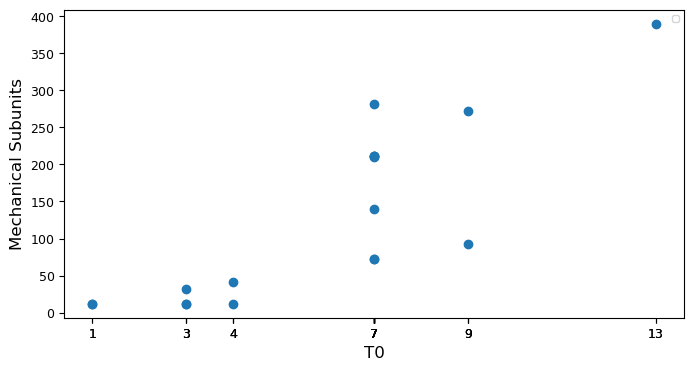

In [5]:
import matplotlib.pyplot as plt
import matplotlib
Ts = np.array(table['T0'])
n_clusts = np.array(table['Mechanical Subunits'])
ind = np.arange(CCs.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.scatter(Ts, n_clusts)
ax.set_ylabel('Mechanical Subunits', fontsize=12)
ax.set_xlabel('T0', fontsize=12)
ax.set_xticks(Ts)
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
ax.legend()
#fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) +  r'$\pm$' + "{:.5f}".format(stderr) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff), fontsize=8)
#plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + pdb + '_sqFlucts_final.svg')
plt.show()